In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from project.dataset import VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, NEWNiftiToTensorTransform
from project.utils import collatev2
from project.utils import compute_statistics
from project.evaluation import isa_rpn_metric, Tracker, SmoothL1GiouLoss, isa_vit_metric

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
rpn_tk = Tracker()

In [3]:
ALPHA = 0.6
BETA = 0.4

### Monitoring and CUDA Setup


In [4]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
os.makedirs('history', exist_ok=True)
rn = dtt.now()
dte = rn.strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('andy')
fh = logging.FileHandler(f'logs/AC_rpn_{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_24_2024_024303'

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
rpn_tk.date = rn
rpn_tk.logfile = f'AC_vit_{dte}.log'
rpn_tk.device = device

### Config for RPN and ViT Fitter


In [7]:
from project.model import RPN, ISAVIT

rpn_config = {
    'model': RPN(
        input_dim=512,
        output_dim=16,
        image_size=300,
        global_context=True,
        nh=4,
        pretrained=False
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 20,
    'loss': nn.BCEWithLogitsLoss(),
    # 'loss': SmoothL1GiouLoss.loss,
    'lr': 0.0001
}

324


C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
rpn_tk.model = 'RPN'
rpn_tk.model_hyperparams = rpn_config['model'].config
rpn_tk.uses_resnet = rpn_config['model'].config['pretrained']
rpn_tk.optimizer = f"{rpn_config['optimizer']}"
rpn_tk.epochs = rpn_config['epochs']
rpn_tk.lr = rpn_config['lr']
rpn_tk.loss = f"{rpn_config['loss']}"

### Dataset Loading


In [9]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

In [10]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
rpn_tk.only_cmb_slices = True
data

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,8,1,1,1,928.405273,35
1,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,9,1,1,1,928.405273,35
2,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,11,1,1,1,928.405273,35
3,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,12,1,1,1,928.405273,35
4,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...,...
359,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,25,1,1,3,241.000000,36
360,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,26,1,1,3,241.000000,36
361,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,24,1,1,3,448.000000,39
362,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,25,1,1,3,448.000000,39


### Preprocessing and Train-Test Split Function


In [11]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None,
                 rpn_tracker=rpn_tk,
                ):
    if cohort == 1:
        rpn_tracker.cohort1 = True
    if cohort == 2:
        rpn_tracker.cohort2 = True
    if cohort == 3:
        rpn_tracker.cohort3 = True
    
    rpn_tracker.test_size = test_size
    data = data[data.cohort == cohort]
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NEWNiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max),
        patch_size=target_shape[0]/(rpn_tracker.model_hyperparams['output_dim']**.5)
    )

    train_set = VALDODataset(
        cases=data_train.stripped.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.stripped.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_set, val_set

### RPN Fitter


In [12]:
from project import Fitter

In [13]:
class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        counter = 0
        for batch in train_loader:
            # self.log('----------------- BATCH -----------------')
            Y = []
            T = []
            for slices, masks, target, case in batch:
                # x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                x = slices.squeeze(1).float().to(self.device)
                masks = masks.squeeze(1).float().to(self.device)
                y = self.model(x, target)

                # dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().clone().numpy(force=True) >= np.median(y.sigmoid().clone().numpy(force=True))), masks[target].unsqueeze(0).clone().numpy(force=True))
                dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().clone().numpy(force=True) >= 0.3), masks[target].unsqueeze(0).clone().numpy(force=True))

                evaluation_metric['dice_score'].append(dice_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                evaluation_metric['fpr'].append(fpr)
                # self.log(f'EVAL METS: {iou_score, precision_score, recall_score, f1_score}')
                Y.append(y)
                T.append(masks[target].unsqueeze(0))
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            # if counter % len(batch) == 0:
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        
        return loss_history, evaluation_metric
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    # x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                    x = slices.squeeze(1).float().to(self.device)
                    masks = masks.squeeze(1).float().to(self.device)
                    y = self.model(x, target)
                    
                    # dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().clone().numpy(force=True) >= np.median(y.sigmoid().clone().numpy(force=True))), masks[target].unsqueeze(0).clone().numpy(force=True))
                    dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().clone().numpy(force=True) >= 0.3), masks[target].unsqueeze(0).clone().numpy(force=True))
                    evaluation_metric['dice_score'].append(dice_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    evaluation_metric['fpr'].append(fpr)
                    
                    Y.append(y)
                    T.append(masks[target].unsqueeze(0))
                losses= self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        self.log(f'\nValidations Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric
                

### Train-Test Split


In [14]:
rpn_t1, rpn_v1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=True
)

rpn_t3, rpn_v3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=True
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [15]:
from torch.utils.data import ConcatDataset

rpn_train_set = ConcatDataset([rpn_t1, rpn_t3])
rpn_test_set = ConcatDataset([rpn_v1, rpn_v3])

print(f'RPN Train Set Size: {rpn_train_set}')
print(f'RPN Test Set Size: {rpn_test_set}')

RPN Train Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000002A106BE1480>
RPN Test Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000002A106BE1450>


In [16]:
batchs = 15

rpn_test_dataloader = DataLoader(
    rpn_test_set,
    shuffle=True,
    batch_size=batchs,
    collate_fn=collatev2
)

### K-Fold Cross Validation


In [17]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=45)
kf

KFold(n_splits=5, random_state=45, shuffle=True)

In [19]:
from project.model import Feeder, GCRPN
from project.preprocessing import NiftiToTensorTransform, get_transform

image_size = 300
patch_size = 32

In [20]:
rpn_test_dice = []
rpn_test_precision = []
rpn_test_recall = []
rpn_test_f1 = []
rpn_test_fpr = []

In [21]:
rpn_fold_metrics = []

fold_dir = f'./fold/{dte}'
os.makedirs(fold_dir, exist_ok=True)

for i, (train_index, val_index) in enumerate(kf.split(rpn_train_set)):
    print(f'Fold {i + 1}/{5}')
    logger.info(f'################################### Fold {i+1}/5 ###################################')
    
    # RPN
    rpn_config['model'] = RPN(**rpn_tk.model_hyperparams).to(device)
    
    rpn_fitter = RPNFitter(rpn_config, logger=logger)
    
    rpn_train_subset = Subset(rpn_train_set, train_index)
    rpn_val_subset = Subset(rpn_train_set, val_index)

    rpn_tk.batch_size = 15
    
    rpn_train_subset_dl = DataLoader(
        rpn_train_subset,
        shuffle=True,
        batch_size=rpn_tk.batch_size,
        collate_fn=collatev2
    )
    
    rpn_val_subset_dl = DataLoader(
        rpn_val_subset,
        shuffle=True,
        batch_size=rpn_tk.batch_size,
        collate_fn=collatev2
    )
    
    rpn_thist, rpn_vhist, rpn_tmhist, rpn_vmhist = rpn_fitter.fit(rpn_train_subset_dl, rpn_val_subset_dl)
    
    rpn_fold_metrics.append({
        'fold': i + 1,
        'training_history': rpn_thist,
        'validation_history': rpn_vhist,
        'training_metrics': rpn_tmhist,
        'validation_metrics': rpn_vmhist
    })
    
    rpn_h, rpn_mh = rpn_fitter.validation(rpn_test_dataloader)
    rpn_valmets = pd.DataFrame(rpn_mh)
    rpn_mets = rpn_valmets.mean()

    rpn_test_dice.append(rpn_mets.dice_score)
    rpn_test_precision.append(rpn_mets.precision_score)
    rpn_test_recall.append(rpn_mets.recall_score)
    rpn_test_f1.append(rpn_mets.f1_score)
    rpn_test_fpr.append(rpn_mets.fpr)
    
    os.makedirs(f'{fold_dir}/fold_{i+1}', exist_ok=True)
    torch.save(rpn_fitter.model.state_dict(), f'{fold_dir}/fold_{i+1}/rpn_fold{i+1}.pt')

    

INFO:andy:################################### Fold 1/5 ###################################


Fold 1/5
324


C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:andy:EPOCH 0 ==============================
C:\Program Files\Python310\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Program Files\Python310\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cud

Fold 2/5
324


INFO:andy:EPOCH 0 ==============================
INFO:andy:Batch:	1/4
INFO:andy:Batch samples:	15
INFO:andy:Current error:	0.6782987117767334

INFO:andy:Batch:	2/4
INFO:andy:Batch samples:	15
INFO:andy:Current error:	0.597597599029541

INFO:andy:Batch:	3/4
INFO:andy:Batch samples:	15
INFO:andy:Current error:	0.536270022392273

INFO:andy:Batch:	4/4
INFO:andy:Batch samples:	13
INFO:andy:Current error:	0.4941810369491577

INFO:andy:
Training Evaluation Metric:
INFO:andy:Avg Dice: 0.15256450828272108
INFO:andy:Avg Precision: 0.08469748642162438
INFO:andy:Avg Recall: 1.0
INFO:andy:Avg F1: 0.1525645082827211
INFO:andy:Avg FPR: 0.4928083407877132

INFO:andy:
Validations Evaluation Metric:
INFO:andy:Avg Dice: 0.23251563251563254
INFO:andy:Avg Precision: 0.13786195286195288
INFO:andy:Avg Recall: 0.8555555555555556
INFO:andy:Avg F1: 0.23251563251563254
INFO:andy:Avg FPR: 0.3498814229249011

INFO:andy:EPOCH 1 ==============================
INFO:andy:Batch:	1/4
INFO:andy:Batch samples:	15
INFO:and

Fold 3/5
324


INFO:andy:EPOCH 0 ==============================
INFO:andy:Batch:	1/4
INFO:andy:Batch samples:	15
INFO:andy:Current error:	0.7248645424842834

INFO:andy:Batch:	2/4
INFO:andy:Batch samples:	15
INFO:andy:Current error:	0.6466466784477234

INFO:andy:Batch:	3/4
INFO:andy:Batch samples:	15
INFO:andy:Current error:	0.5853241682052612

INFO:andy:Batch:	4/4
INFO:andy:Batch samples:	13
INFO:andy:Current error:	0.5283371806144714

INFO:andy:
Training Evaluation Metric:
INFO:andy:Avg Dice: 0.1477326472028617
INFO:andy:Avg Precision: 0.08143709738537325
INFO:andy:Avg Recall: 1.0
INFO:andy:Avg F1: 0.1477326472028617
INFO:andy:Avg FPR: 0.4975345865655021

INFO:andy:
Validations Evaluation Metric:
INFO:andy:Avg Dice: 0.22871739371739372
INFO:andy:Avg Precision: 0.13354201354201353
INFO:andy:Avg Recall: 1.0
INFO:andy:Avg F1: 0.22871739371739372
INFO:andy:Avg FPR: 0.4237964422162323

INFO:andy:EPOCH 1 ==============================
INFO:andy:Batch:	1/4
INFO:andy:Batch samples:	15
INFO:andy:Current erro

Fold 4/5
324


INFO:andy:EPOCH 0 ==============================
INFO:andy:Batch:	1/4
INFO:andy:Batch samples:	15
INFO:andy:Current error:	0.6731388568878174

INFO:andy:Batch:	2/4
INFO:andy:Batch samples:	15
INFO:andy:Current error:	0.6071822643280029

INFO:andy:Batch:	3/4
INFO:andy:Batch samples:	15
INFO:andy:Current error:	0.55046147108078

INFO:andy:Batch:	4/4
INFO:andy:Batch samples:	14
INFO:andy:Current error:	0.48832038044929504

INFO:andy:
Training Evaluation Metric:
INFO:andy:Avg Dice: 0.16267527825879077
INFO:andy:Avg Precision: 0.09069814366424535
INFO:andy:Avg Recall: 1.0
INFO:andy:Avg F1: 0.16267527825879077
INFO:andy:Avg FPR: 0.4975987927478284

INFO:andy:
Validations Evaluation Metric:
INFO:andy:Avg Dice: 0.15959754531183099
INFO:andy:Avg Precision: 0.08745421245421246
INFO:andy:Avg Recall: 0.9285714285714286
INFO:andy:Avg F1: 0.159597545311831
INFO:andy:Avg FPR: 0.3958864203429421

INFO:andy:EPOCH 1 ==============================
INFO:andy:Batch:	1/4
INFO:andy:Batch samples:	15
INFO:and

Fold 5/5
324


INFO:andy:EPOCH 0 ==============================
INFO:andy:Batch:	1/4
INFO:andy:Batch samples:	15
INFO:andy:Current error:	0.7076820135116577

INFO:andy:Batch:	2/4
INFO:andy:Batch samples:	15
INFO:andy:Current error:	0.632920503616333

INFO:andy:Batch:	3/4
INFO:andy:Batch samples:	15
INFO:andy:Current error:	0.5740301012992859

INFO:andy:Batch:	4/4
INFO:andy:Batch samples:	14
INFO:andy:Current error:	0.5254561305046082

INFO:andy:
Training Evaluation Metric:
INFO:andy:Avg Dice: 0.16059263729279982
INFO:andy:Avg Precision: 0.0894774011299435
INFO:andy:Avg Recall: 1.0
INFO:andy:Avg F1: 0.16059263729279982
INFO:andy:Avg FPR: 0.4984955733056259

INFO:andy:
Validations Evaluation Metric:
INFO:andy:Avg Dice: 0.1559654631083202
INFO:andy:Avg Precision: 0.08505185290899575
INFO:andy:Avg Recall: 1.0
INFO:andy:Avg F1: 0.15596546310832024
INFO:andy:Avg FPR: 0.4373233908948196

INFO:andy:EPOCH 1 ==============================
INFO:andy:Batch:	1/4
INFO:andy:Batch samples:	15
INFO:andy:Current error

In [22]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

### Metrics Visualization


`rpn_fold_metrics[i]`

- represents each fold

`rpn_fold_metrics[1].keys()`

- 'fold', 'training_history', 'validation_history', 'training_metrics', 'validation_metrics'

`rpn_fold_metrics[1]['training_metrics'][i]`

- represents each epoch

`rpn_fold_metrics[1]['training_metrics'][1].keys()`

- 'iou_score', 'precision_score', 'recall_score', 'f1_score'


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [24]:
def plot_metric_history(fold_metrics, metric, title=None):
    avg_train = []
    avg_test = []

    for fold in range(len(fold_metrics)):
        train = []
        test = []
        
        for epoch in range(len(fold_metrics[fold]['training_metrics'])):
            th = np.array(fold_metrics[fold]['training_metrics'][epoch][metric]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_metrics'][epoch][metric]).mean()
            test.append(vh)
            
        avg_train.append(np.array(train))
        avg_test.append(np.array(test))
    
    epochs = len(np.mean(avg_train, axis=0)) + 1
            
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_train, axis=0), label=f'Training {metric}')
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_test, axis=0), label=f'Validation {metric}')
    
    plt.title(f'{title} - Training and Validation {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
        
    plt.tight_layout()  
    plt.show()

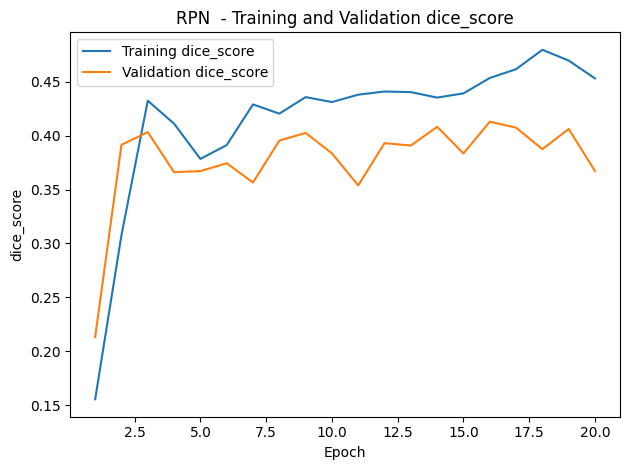

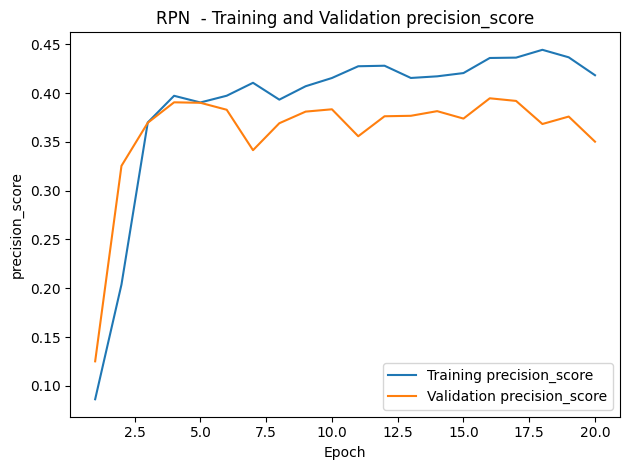

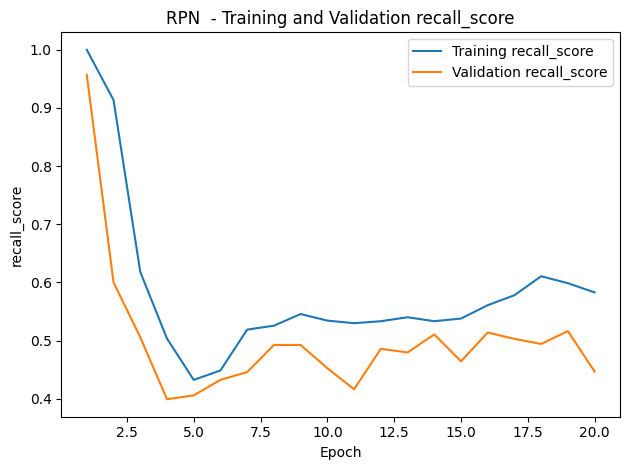

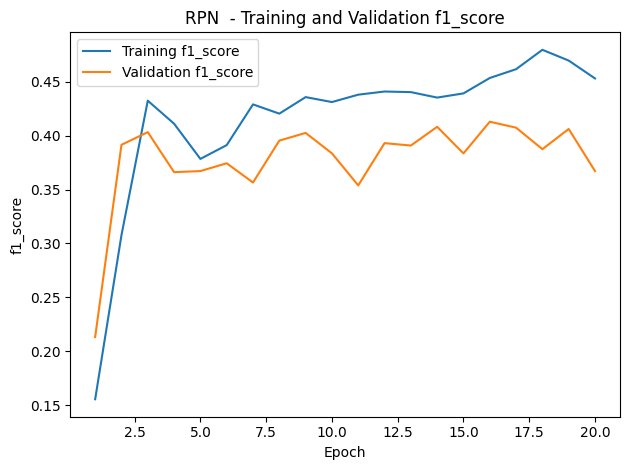

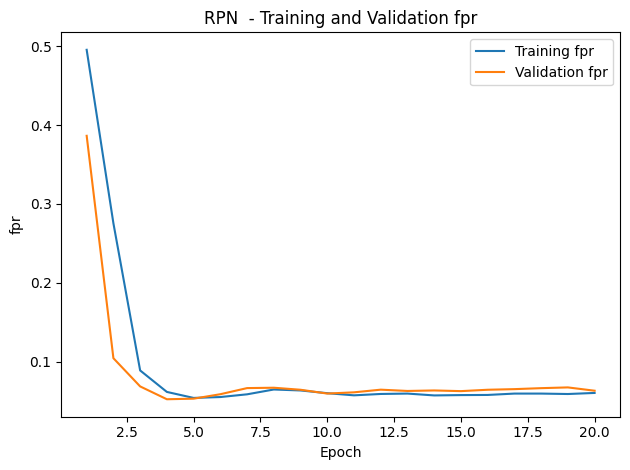

In [25]:
rpn_metrics = ['dice_score', 'precision_score', 'recall_score', 'f1_score', 'fpr']

for metric in rpn_metrics:
    plot_metric_history(rpn_fold_metrics, metric, 'RPN ')

### Loss History Visualization


In [26]:
def plot_loss_history(fold_metrics, title=None):
    avg_train = []
    avg_test = []

    for fold in range(len(fold_metrics)):
        train = []
        test = []
        
        for epoch in range(len(fold_metrics[fold]['training_history'])):
            th = np.array(fold_metrics[fold]['training_history'][epoch]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_history'][epoch]).mean()
            test.append(vh)
            
        avg_train.append(np.array(train))
        avg_test.append(np.array(test))
    
    epochs = len(np.mean(avg_train, axis=0)) + 1
        
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_train, axis=0), label='Training history')
    sns.lineplot(x=range(1, epochs), y=np.mean(avg_test, axis=0), label='Validation history')
        
    plt.title(f'{title} - Training and Validation history')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    
    plt.tight_layout()  
    plt.show()

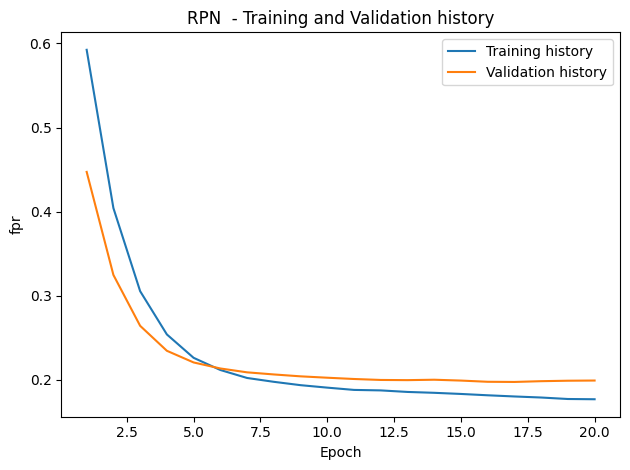

In [27]:
plot_loss_history(rpn_fold_metrics, 'RPN ')
# plot_loss_history(vit_fold_metrics, 'ViT ')

### Evaluate Test Set


#### RPN


In [28]:
df_rpn_metrics = pd.DataFrame(columns=['fold', 'dice', 'precision', 'recall', 'f1', 'fpr'])
df_rpn_metrics

,fold,dice,precision,recall,f1,fpr


In [29]:
df_rpn_metrics['fold'] = [1, 2, 3, 4, 5]
df_rpn_metrics['dice'] = rpn_test_dice
df_rpn_metrics['precision'] = rpn_test_precision
df_rpn_metrics['recall'] = rpn_test_recall
df_rpn_metrics['f1'] = rpn_test_f1
df_rpn_metrics['fpr'] = rpn_test_fpr

In [30]:
rpn_tk.dice = df_rpn_metrics.dice.mean()
rpn_tk.precision = df_rpn_metrics.precision.mean()
rpn_tk.recall = df_rpn_metrics.recall.mean()
rpn_tk.f1 = df_rpn_metrics.f1.mean()
rpn_tk.fpr = df_rpn_metrics.fpr.mean()

In [31]:
df_rpn_metrics

,fold,dice,precision,recall,f1,fpr
0,1,0.219298,0.236842,0.236842,0.219298,0.032946
1,2,0.236842,0.263158,0.236842,0.236842,0.064293
2,3,0.201754,0.210526,0.236842,0.201754,0.070872
3,4,0.324561,0.298246,0.421053,0.324561,0.069389
4,5,0.315789,0.280702,0.421053,0.315789,0.082005


In [32]:
rpn_dice_score = np.array(rpn_test_dice).mean()
rpn_precision_score = np.array(rpn_test_precision).mean()
rpn_recall_score = np.array(rpn_test_recall).mean()
rpn_f1_score = np.array(rpn_test_f1).mean()
rpn_fpr_score = np.array(rpn_test_fpr).mean()

print('RPN Test Set Performance Metrics')
print(f'Average Dice Score: {rpn_dice_score} ')
print(f'Average Precision: {rpn_precision_score} ')
print(f'Average Recall: {rpn_recall_score} ')
print(f'Average F1 Score: {rpn_f1_score} ')
print(f'Average FPR: {rpn_fpr_score} ')

RPN Test Set Performance Metrics
Average Dice Score: 0.2596491228070175 
Average Precision: 0.2578947368421053 
Average Recall: 0.31052631578947365 
Average F1 Score: 0.2596491228070175 
Average FPR: 0.06390092879256966 


In [33]:
df_rpn_metrics.to_csv(f'{fold_dir}/rpn_metrics.csv')

In [34]:
df_rpn_metrics.to_csv(f'./statistical-treatment/isa-rpn.csv')

In [35]:
while True:
    winsound.Beep(500, 1000)

KeyboardInterrupt: 

### Sample


In [ ]:
import matplotlib.patches as patches

In [ ]:
sample = next(iter(rpn_test_dataloader))

for i in range(len(next(iter(rpn_test_dataloader)))):
    rpn_slices, rpn_masks, rpn_target, rpn_case = sample[i]
    
    rpn_x = rpn_slices.squeeze(1).float().to(device)
    rpn_T = rpn_masks.squeeze(1).float().to(device)
    rpn_y = rpn_fitter.model(rpn_x, rpn_target)
    
    rpn_fitter.loss(rpn_y, rpn_T[rpn_target])
    rpn_bbox = rpn_masks[rpn_target].squeeze().cpu().long()
    rpn_y = (rpn_y*300).squeeze().detach().cpu().long()
    
    ax = sns.heatmap(rpn_x[rpn_target][0].squeeze().cpu(), cmap='gray')

    truth = patches.Rectangle(
        (rpn_bbox[0], rpn_bbox[1]),
        rpn_bbox[2] - rpn_bbox[0],
        rpn_bbox[3] - rpn_bbox[1],
        linewidth=1, edgecolor='g', facecolor='none'
    )

    pred = patches.Rectangle(
        (rpn_y[0], rpn_y[1]),
        rpn_y[2] - rpn_y[0],
        rpn_y[3] - rpn_y[1],
        linewidth=1, edgecolor='r', facecolor='none'
    )

    ax.add_patch(truth)
    ax.add_patch(pred)
    plt.show()

# Log Progress


In [ ]:
rpn_tk.notes = '''
Global Context
'''

In [ ]:
rpn_tk()

In [ ]:
if os.path.exists('history/runs.csv'):
    print('Merging to old df')
    prev_df = pd.read_csv('history/runs.csv', index_col='date')
    merged = pd.concat([prev_df, rpn_tk()])
    merged.to_csv('history/runs.csv')
else:
    print('Making new csv file')
    rpn_tk().to_csv('history/runs.csv')